## Quantitative Methods 2:  Data Science and Visualisation

## Workshop 8: Working with Spatiotemporal Data
In this workshop, we will work with data that information about space and time, and show different ways of presenting this data, with the goal of producing fully-fledged maps.

### Aims:

- Plot and summarise spatial data
- Create simple point maps
- Understand the basics of projection

In [1]:
#install geopandas....

## Downloading the Data
Let's grab the data we will need this week from our course website and save it into our data folder. If you've not already created a data folder then do so using the following command. 

Don't worry if it generates an error, that means you've already got a data folder.

In [2]:
!mkdir data

mkdir: cannot create directory 'data': File exists


In [1]:
!mkdir data/wk8
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk8/tweet_data.csv -o ./data/wk8/tweet_data.csv

mkdir: cannot create directory ‘data/wk8’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  156k  100  156k    0     0   104k      0  0:00:01  0:00:01 --:--:--  104k


`------------------------------`

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab

%matplotlib inline
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (10, 8)

## Point and Areal Data

We're going to look at some *point data*, data which has a spatial location but not an extent - this can be contrasted with *areal data*, where data is reported or represented as covering, or relating to, a specific region geography. An example of this second category would be the released census geography - which, as we saw earlier in the term, is reported on a bespoke areal unit called the Output Area.

Today we will look at point data. For the purpose, we'll be looking at some data from twitter - data which has detailed spatial position as well as time and date.

## The birds sing a pretty song

Let's start by loading in the twitter data and running head() to take a look at what the dataset contains. The dataset has information about tweeters but not the content of the tweets:

### JUST TO NOTE BELOW ADDED "encoding = "mac_roman"," as it wasn't working in normal utf-8 encoding for me.

In [18]:
data_path = "./data/wk8/tweet_data.csv"

tweets = pd.read_csv(data_path, parse_dates=[1], encoding = "mac_roman", infer_datetime_format=True)
tweets.head()

,id,dateT,name,Lat,Lon,OSGB_Lon,OSGB_Lat
0,15,2010-04-28 15:03:00,MrFlexDot (Felix Tekyi),51.682488,-0.045406,535225.835914,200000.009703
1,19,2010-04-28 15:03:00,genyfrmdablck (geny ),51.539869,-0.135413,529408.436064,183977.283107
2,26,2010-04-28 15:03:00,makapala (Dave Woodford),51.459499,-0.036607,536499.925360,175219.249296
3,31,2010-04-28 15:03:00,JayVades (JayVades),51.518075,0.024400,540557.757933,181848.336146
4,38,2010-04-28 15:03:00,CatchAChoo (Jimmy Choo),51.510000,-0.217000,523831.617422,180514.655542


## Exercise
What does each data column represent?

        id = id, dateT = datetime, name = twitter handle + nickname, lat = latitude position, long  = longitude position, OSGB_Lon, = Ordnance Survey National Grid longtitude, OSGB_Lat = Ordnance Survey National Grid Latitude
       

## Working with datetime data
Datetime data is a little trickier to work with - it has structure which allows the extraction of hours, minutes, seconds, and so on. For example, we can just take the time part: 

In [13]:
tweets['dateT'].dt.time.head()

0    15:03:00
1    15:03:00
2    15:03:00
3    15:03:00
4    15:03:00
Name: dateT, dtype: object

## Exercise
What temporal extent does the data cover? How do we need to structure our approach?

In [22]:
print(tweets['dateT'].min())
print(tweets['dateT'].max())

2010-04-28 15:03:00
2010-04-28 15:48:00


## Exercise
Create a new column in the dataframe which stores the "minute" component of the timestamp, and use it to create a histogram of the data over the course of an hour in five minute intervals. Make sure that your graph includes a title and labelled axes.

Text(0.5, 1.0, 'Number of Tweets per 5 Minute Interval')

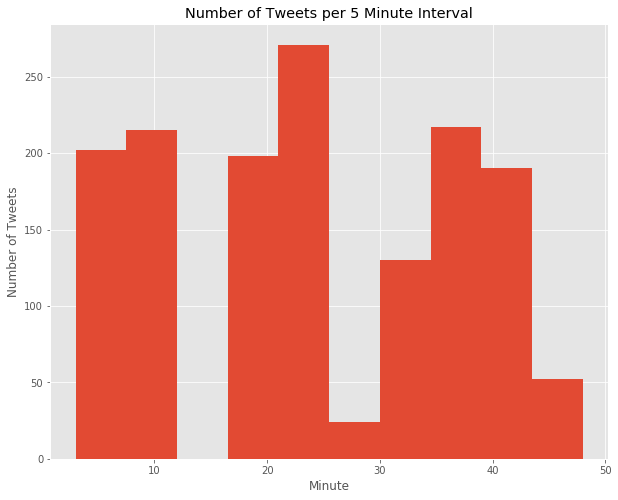

In [29]:
tweets['minute'] = tweets['dateT'].dt.minute
tweets['minute'].hist()
plt.xlabel("Minute")
plt.ylabel("Number of Tweets")
plt.title("Number of Tweets per 5 Minute Interval")

You can also execuate this code in one line if you don't mind seeing a lot of dots - I've not included the parameters to give this some polish -  we will leave that as an exercise.

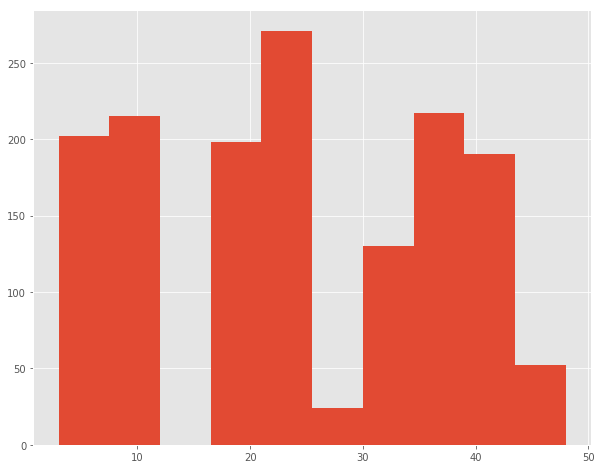

In [15]:
tweets['dateT'].dt.minute.hist()

## My First Map
The beauty of this data is that the data points have x and y values, so plotting them as a scatter graph will give us out first approximation (with caveats) of a map of the data:

Text(0, 0.5, 'Latitude [degrees]')

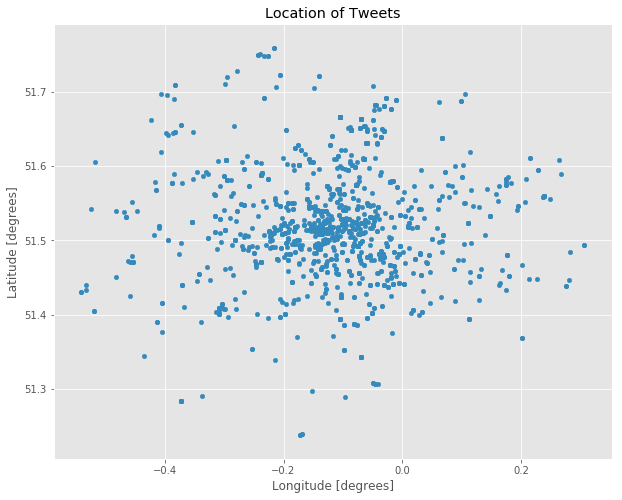

In [30]:
tweets.plot(
    kind='scatter',
    x='Lon',
    y='Lat',
    title="Location of Tweets")
plt.xlabel("Longitude [degrees]")
plt.ylabel("Latitude [degrees]")

Notice that we've laid out the code so it's easier to see the multiple arguments in plot() - this is just the same as:

Text(0, 0.5, 'Latitude [degrees]')

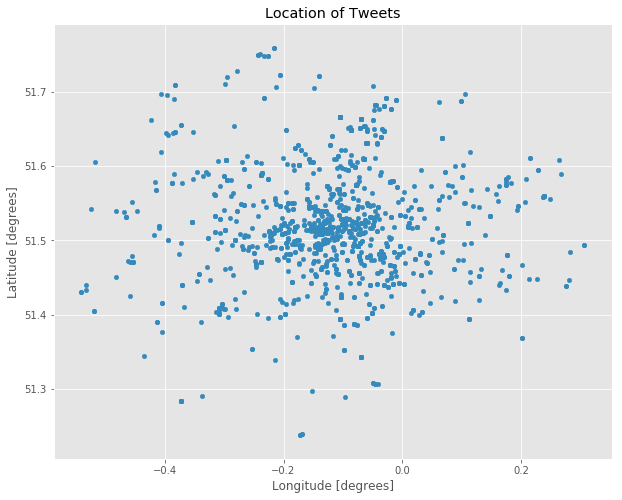

In [31]:
tweets.plot(kind='scatter',x='Lon',y='Lat', title="Location of Tweets")
plt.xlabel("Longitude [degrees]")
plt.ylabel("Latitude [degrees]")

## Exercise
Change the style of the above map using the optional arguments:

- *alpha = *: to set the opacity - 1 being opaque and 0 being transparent. Set the transparecny so that you can see busy areas *and* individual points
- *color=*: to set the colo*u*r to 'red'
- *s=*: so set the point size to 50

So we have something that looks a bit like a heat map, and even looks a bit Gaussian. Let's see what a histogram of this data looks like:

Text(0, 0.5, 'Number of Tweets')

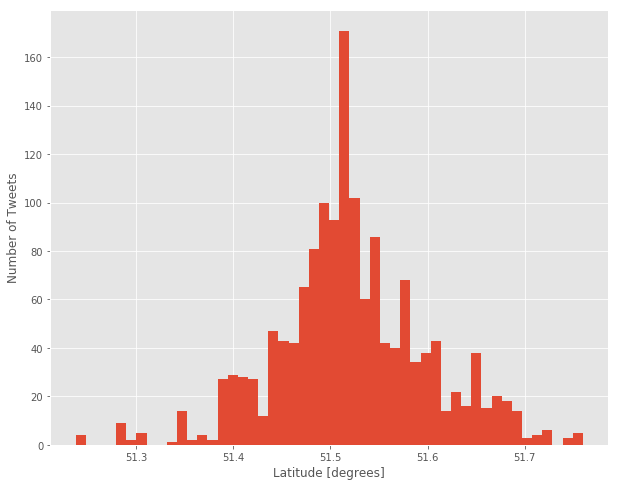

In [32]:
tweets['Lat'].hist(bins = 50)
plt.xlabel("Latitude [degrees]")
plt.ylabel("Number of Tweets")

Text(0, 0.5, 'Number of Tweets')

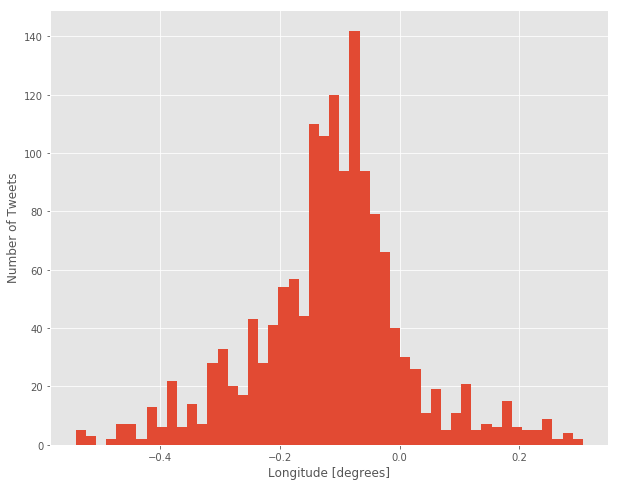

In [33]:
ax = tweets['Lon'].hist(bins=50)
plt.xlabel("Longitude [degrees]")
ax.set_ylabel("Number of Tweets")

## The Naivest Projection

The above tweet plot implicitly uses the *equirectangular* projection, which maps longitude onto the x axis, and latitude onto the y axis. What is the problem with this ? 

Projection is hugely complex and mathematically fiddly - luckily, we'll be working with packages which mostly do the heavy lifting for us. It's still worth thinking about projection a bit, as the process of taking points on a sphere and translating that to a flat surface is never a perfect one.

If  we look at the picture below, then clearly the distance between $p$ and $q$ is the length of the curve on the sphere rather than the straight line between them. The closer $p$ and $q$ are the more the distance is like a straight line, and we can use a *linear mapping* - i.e. the x coordinate is a linear function of lon, and the y axis is a linear function of latitude.

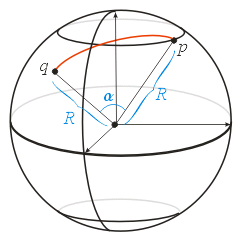

In [34]:
from IPython.display import Image
Image("https://s3.eu-west-2.amazonaws.com/qm2/wk8/great-circle-distance.png")

## Extension: Not-so-great circles

Calculating great circle distances is the "real" way of figuring out the distance between two points on a sphere is fairly complex. Thankfully, there's a small angle approximation. 

If the two points (1 and 2) have latitudes $\phi_1$ and $\phi_2$ and longitudes $\lambda_1$ and $\lambda_2$, then let $\Delta\phi = \phi_1 - \phi_2$ and $\Delta\lambda = \lambda_1 - \lambda_2$ , where $(\phi_1,\lambda_1) ,(\phi_2,\lambda_2)$ are two points given in (latitude, longitude).  

If $\Delta\phi$ and $\Delta\lambda$ are small enough, you can calculate the distance $D$ with : 

$$D = R \sqrt{(\Delta\phi)^2+(cos(\bar{\phi})\Delta\lambda)^2}$$


where $\bar{\phi}$ is the mean latitude of the two points, $\frac{1}{2}(\phi_1+\phi_2)$, and R is the radius of the earth. 

How small is small enough if we want to use this approximation? Well, it depends on how much error you want to incur. But generally if the angles are much less than one radian, you'll incur small errors. Radians, you say? Yes, everything in the above equations assumes angles are expressed in radians. 1 radian is about 57 degrees, but there are more precise definitions, and python has a utility function for converting between the two.

For reference, the errors accumulated over the size of London are tens of metres.

## British Values

The British National Grid provides projected values in metres, so we can get by without doing projections "on the fly" just yet. If we plot these values, it will look pretty similar, for the reasons outlined above - over the few km of London, most projection methods are quite close to the linear mapping we've done.

Text(0, 0.5, 'projected Latitude')

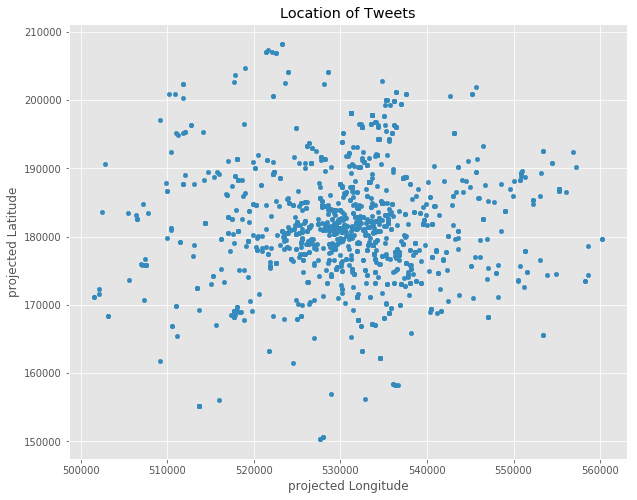

In [35]:
ax = tweets.plot(
    kind='scatter',
    x='OSGB_Lon',
    y='OSGB_Lat',
    title="Location of Tweets")
ax.set_xlabel("projected Longitude")
ax.set_ylabel("projected Latitude")

## Exercise: Describing the Data

1) Find the data centroid (lat, lon)

2) Calculate the x, y and total extent of the data, in km (or miles). (Use the projected [OSGB] data for that.)

Hint: use commands which capture the maximum, minimum and mean of the data - describe() is a useful one here.


In [41]:
sumlon = tweets['OSGB_Lon'].sum()
lenlon = len(tweets['OSGB_Lon'])
meanlon = sumlon/lenlon
sumlat = tweets['OSGB_Lat'].sum()
lenlat = len(tweets['OSGB_Lat'])
meanlat = sumlat/lenlat
print("(", str(meanlon), ", ", str(meanlat),")")

( 530911.8987057578 ,  182019.43661756723 )


## Exercise

How might we go about calculating the geographical extent which contained 95% of tweets? Assuming the distribution is Gaussian in both variables, estimate a) the latitude the limits which contain 95% of tweets, b) the longitude limits which contain 95% of tweets. Then c) and add lines showing these limits to the tweet graph and d) save the figure as an image using plt.savefig(*filename*).

What proportion of tweets is held within this box?

How do you think the following elements influence the above result?

- The 2D nature of the data

- Asymmetry of the Gaussian (i.e. if $\sigma_x \neq \sigma_y$)

- Whether the data is Gaussian!

- What other approaches could you take with this data?

In [50]:
std_lon = tweets['OSGB_Lon'].std()
std_lat = tweets['OSGB_Lat'].std()
lat5 = meanlat - 2*std_lat
lat95 = meanlat + 2*std_lat
lon5 = meanlon - 2*std_lon
lon95 = meanlon + 2*std_lon

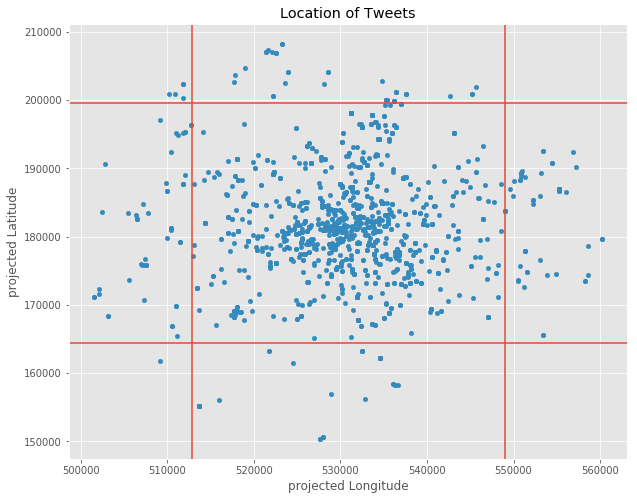

In [56]:
ax = tweets.plot(
    kind='scatter',
    x='OSGB_Lon',
    y='OSGB_Lat',
    title="Location of Tweets")
ax.set_xlabel("projected Longitude")
ax.set_ylabel("projected Latitude")
ax.axvline(lon5)
ax.axvline(lon95)
ax.axhline(lat5)
ax.axhline(lat95)
plt.savefig("./data/wk8/tweetmapnobackground.png")

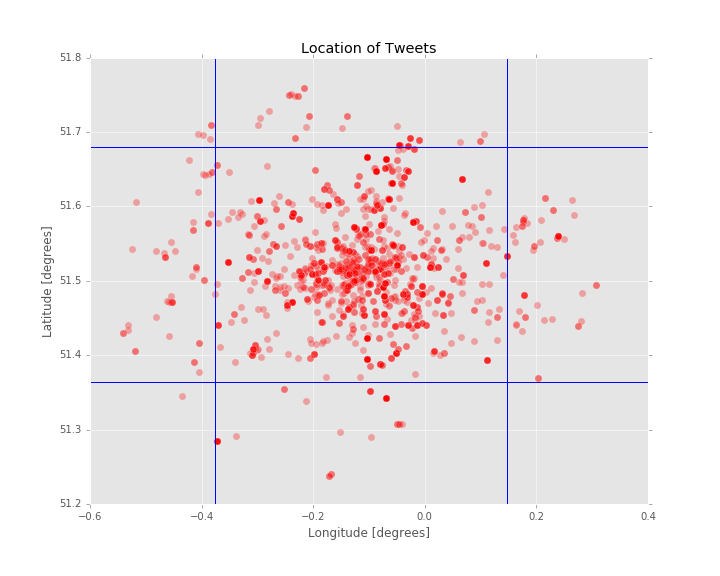

In [57]:
Image("https://s3.eu-west-2.amazonaws.com/qm2/wk8/tweets.png")

## Working in 2D

It's clear that we can learn from 1D about how we can approach 2D data. But there are limitations, and treating 2D as two sets of 1D data doesn't work for everything. We need to find ways to carry out histograms and other aggregations in 2D - and the first of these is hexbinning.

## Hexbinning

We can also use a [hexbin clustering](http://pandas-docs.github.io/pandas-docs-travis/visualization.html#hexagonal-bin-plot) method, which is similar to binning in a histogram, the more points we have in hexbin the warmer the color. Here, we count the number data points in each hexagons, in the same way that we count the number of data in each bin for 1D data

Luckily, the code is very easy to execute, and requires only small changes:

Text(0, 0.5, 'projected Latitude')

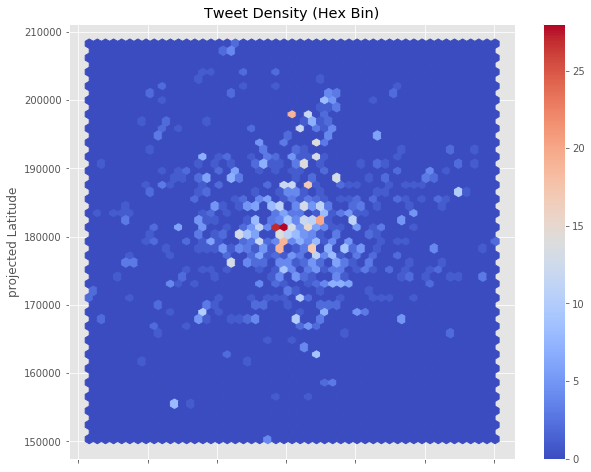

In [58]:
ax = tweets.plot(
    kind='hexbin',
    x='OSGB_Lon', y='OSGB_Lat',
    gridsize=50,
    title="Tweet Density (Hex Bin)",
    cmap='coolwarm',
    )
plt.xlabel("projected Longitude")
plt.ylabel("projected Latitude")

Possible values are: Spectral, summer, coolwarm, Wistia_r, pink_r, Set1, Set2, Set3, brg_r, Dark2, prism, PuOr_r, afmhot_r, terrain_r, PuBuGn_r, RdPu, gist_ncar_r, gist_yarg_r, Dark2_r, YlGnBu, RdYlBu, hot_r, gist_rainbow_r, gist_stern, PuBu_r, cool_r, cool, gray, copper_r, Greens_r, GnBu, gist_ncar, spring_r, gist_rainbow, gist_heat_r, Wistia, OrRd_r, CMRmap, bone, gist_stern_r, RdYlGn, Pastel2_r, spring, terrain, YlOrRd_r, Set2_r, winter_r, PuBu, RdGy_r, spectral, rainbow, flag_r, jet_r, RdPu_r, gist_yarg, BuGn, Paired_r, hsv_r, bwr, cubehelix, Greens, PRGn, gist_heat, spectral_r, Paired, hsv, Oranges_r, prism_r, Pastel2, Pastel1_r, Pastel1, gray_r, jet, Spectral_r, gnuplot2_r, gist_earth, YlGnBu_r, copper, gist_earth_r, Set3_r, OrRd, gnuplot_r, ocean_r, brg, gnuplot2, PuRd_r, bone_r, BuPu, Oranges, RdYlGn_r, PiYG, CMRmap_r, YlGn, binary_r, gist_gray_r, Accent, BuPu_r, gist_gray, flag, bwr_r, RdBu_r, BrBG, Reds, Set1_r, summer_r, GnBu_r, BrBG_r, Reds_r, RdGy, PuRd, Accent_r, Blues, autumn_r, autumn, cubehelix_r, nipy_spectral_r, ocean, PRGn_r, Greys_r, pink, binary, winter, gnuplot, RdYlBu_r, hot, YlOrBr, coolwarm_r, rainbow_r, Purples_r, PiYG_r, YlGn_r, Blues_r, YlOrBr_r, seismic, Purples, seismic_r, RdBu, Greys, BuGn_r, YlOrRd, PuOr, PuBuGn, nipy_spectral, afmhot

## Extension: Splitting Mapping Data by Time

In the next section, we use both space and time to show different geographical distributions at different times. We'll select on index, splitting the dataset in two.

In [59]:
early = tweets[:750]
late = tweets[750:len(tweets)]

In [60]:
early.head()

,id,dateT,name,Lat,Lon,OSGB_Lon,OSGB_Lat,minute
0,15,2010-04-28 15:03:00,MrFlexDot (Felix Tekyi),51.682488,-0.045406,535225.835914,200000.009703,3
1,19,2010-04-28 15:03:00,genyfrmdablck (geny ),51.539869,-0.135413,529408.436064,183977.283107,3
2,26,2010-04-28 15:03:00,makapala (Dave Woodford),51.459499,-0.036607,536499.925360,175219.249296,3
3,31,2010-04-28 15:03:00,JayVades (JayVades),51.518075,0.024400,540557.757933,181848.336146,3
4,38,2010-04-28 15:03:00,CatchAChoo (Jimmy Choo),51.510000,-0.217000,523831.617422,180514.655542,3


In [61]:
late.head()

,id,dateT,name,Lat,Lon,OSGB_Lon,OSGB_Lat,minute
750,4535,2010-04-28 15:23:00,nadyavr (Nadya Valenza R),51.520975,-0.049123,535448.286382,182032.267058,23
751,4539,2010-04-28 15:23:00,janasanchez (Jana Sanchez),51.481550,-0.188767,525869.039823,177399.005684,23
752,4543,2010-04-28 15:23:00,BUMSHA (Bunmi Olowoporoku?),51.663310,-0.068944,533655.100907,197824.013895,23
753,4556,2010-04-28 15:23:00,MrBell74 (Colin Bell),51.467061,0.201290,553000.411504,176530.046180,23
754,4569,2010-04-28 15:23:00,DineHard (Neil Davey),51.470925,-0.237811,522492.091850,176134.358324,23


## Exercise
Plot both sets of tweets onto the same axes so they can be compared. Try and make your plot look like the image below.

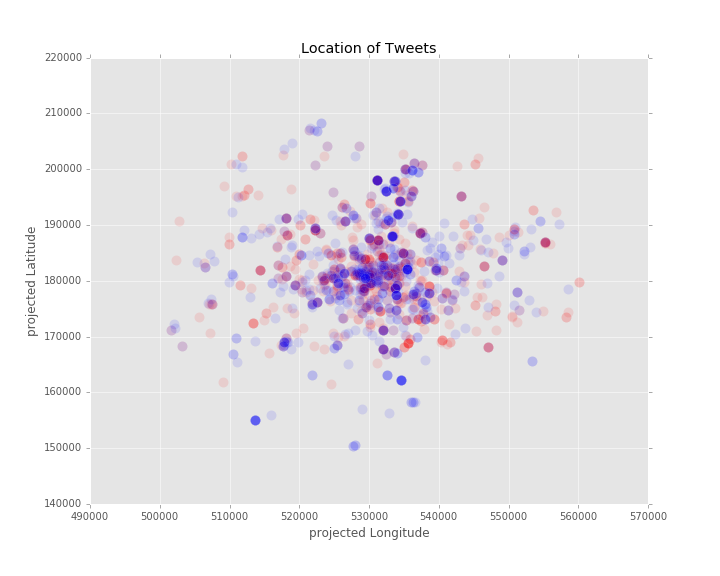

In [62]:
Image("https://s3.eu-west-2.amazonaws.com/qm2/wk8/two_times.png")

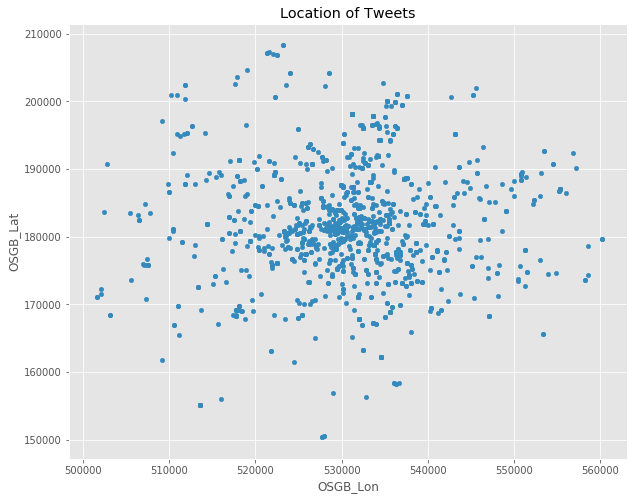

In [68]:
ax = early.plot(kind= 'scatter',
               x= 'OSGB_Lon',
               y ='OSGB_Lat',
               title='Location of Tweets')
late.plot(kind='scatter',
         x= 'OSGB_Lon',
         y ='OSGB_Lat',
         ax = ax)

We can visually inspect the spatial plots of the two time frames using hexbin plots; in this case there's not much to see...

Text(0, 0.5, 'projected Latitude')

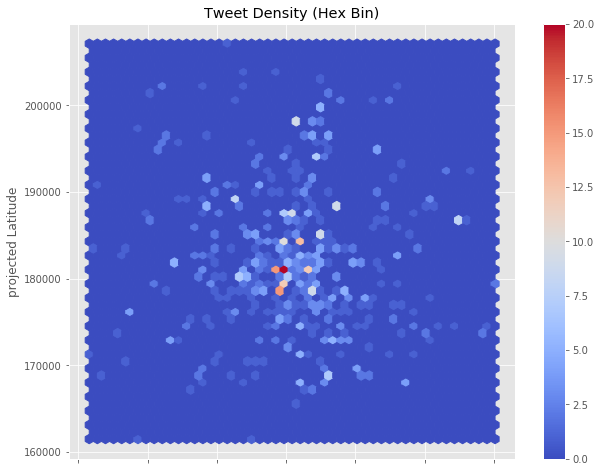

In [69]:
ax = early.plot(
    kind='hexbin',
    x='OSGB_Lon', 
    y='OSGB_Lat',
    gridsize=50,
    title="Tweet Density (Hex Bin)",
    cmap='coolwarm',
    )
plt.xlabel("projected Longitude")
plt.ylabel("projected Latitude")

Text(0, 0.5, 'projected Latitude')

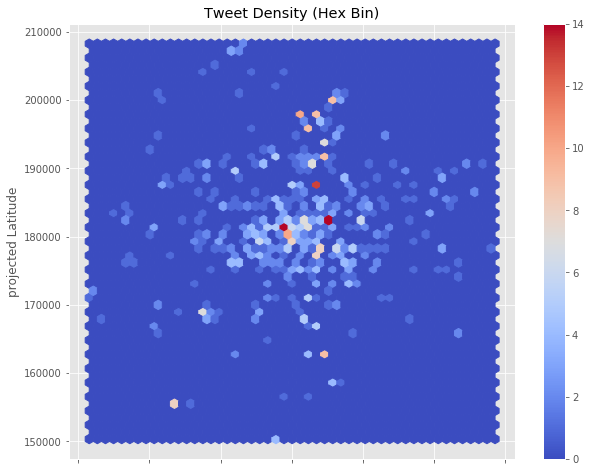

In [70]:
ax = late.plot(
    kind='hexbin',
    x='OSGB_Lon', 
    y='OSGB_Lat',
    gridsize=50,
    title="Tweet Density (Hex Bin)",
    cmap='coolwarm',
    )
plt.xlabel("projected Longitude")
plt.ylabel("projected Latitude")